In [26]:
# from example notebook
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50
PARAMETER_COUNT = [512, 256, 128, 64, 32, 16, 8]

In [27]:
# from example notebook
data = []

for root, subdirs, files in os.walk('dataset/xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/160 [00:00<?, ?it/s]

In [40]:
# from example notebook
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'caret', 'left_curly_brace', 'circle', 'left_sq_bracket', 'star', 'right_curly_brace', 'question_mark', 'rectangle', 'check', 'v', 'right_sq_bracket', 'delete_mark', 'x', 'triangle', 'pigtail', 'arrow'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(128, 50, 2) (32, 50, 2) (128, 16) (32, 16)


In [41]:
eval_array = []
predict_durations = []

test_data = random.sample(data, 1)[0]
sequence = test_data[1]

for i in range(len(PARAMETER_COUNT)):
    print(PARAMETER_COUNT[i])
    # from example notebook
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(PARAMETER_COUNT[i], input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    start_time = time.time()
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )

    end_time = time.time()
    duration = end_time - start_time
    eval = model.evaluate(X_test, y_test)
    eval.append(duration)
    eval.append(PARAMETER_COUNT[i])
    eval_array.append(eval)

    start_predict_time = time.time()
    prediction = model.predict(np.array([sequence]))
    end_predict_time = time.time()
    predict_duration = []
    predict_duration.append(end_predict_time - start_predict_time)
    predict_duration.append(PARAMETER_COUNT[i])
    predict_durations.append(predict_duration)

    

512
Epoch 1/50
4/4 [==============================] - 2s 366ms/step - loss: 2.7054 - accuracy: 0.1406 - val_loss: 2.4923 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 1s 214ms/step - loss: 2.3837 - accuracy: 0.3438 - val_loss: 2.2302 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 1s 207ms/step - loss: 2.0553 - accuracy: 0.4141 - val_loss: 1.9340 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 1s 208ms/step - loss: 1.7009 - accuracy: 0.4766 - val_loss: 1.6809 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 1s 216ms/step - loss: 1.3884 - accuracy: 0.4844 - val_loss: 1.9989 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 1s 208ms/step - loss: 1.2700 - accuracy: 0.5312 - val_loss: 1.4179 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 1s 208ms/step - loss: 1.0798

In [42]:
eval_array

[[0.32636064291000366, 0.90625, 14.669331312179565, 512],
 [0.20780394971370697, 0.90625, 7.07509708404541, 256],
 [0.2574940025806427, 0.96875, 4.935712814331055, 128],
 [0.06424124538898468, 1.0, 5.5548412799835205, 64],
 [0.5156607627868652, 0.90625, 3.7819111347198486, 32],
 [0.9250230193138123, 0.53125, 4.218815565109253, 16],
 [1.494992971420288, 0.375, 3.577469825744629, 8]]

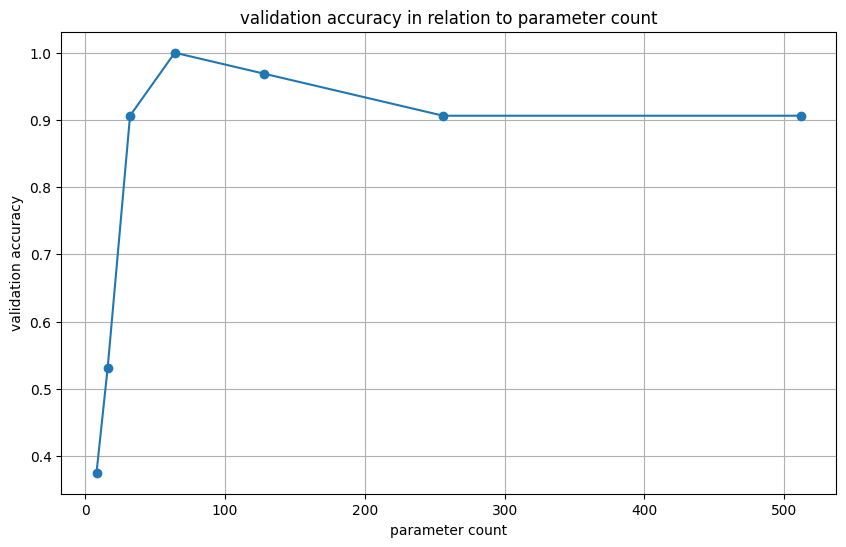

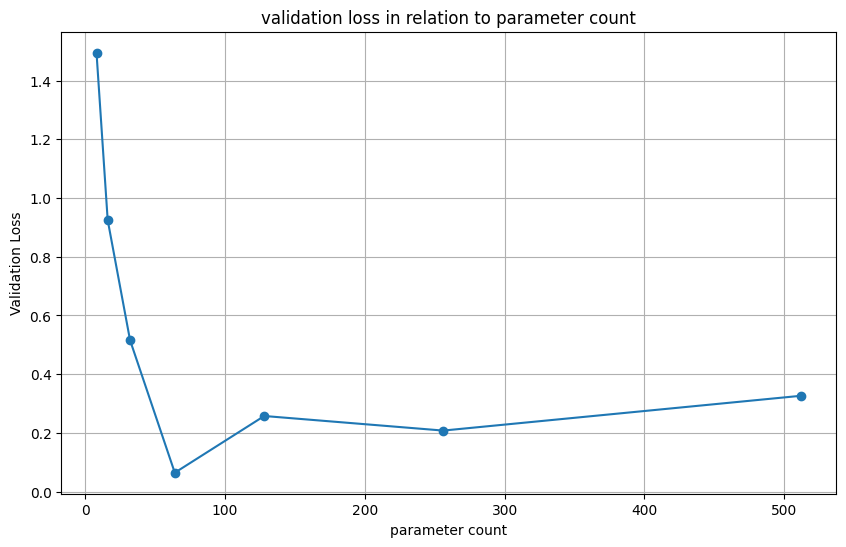

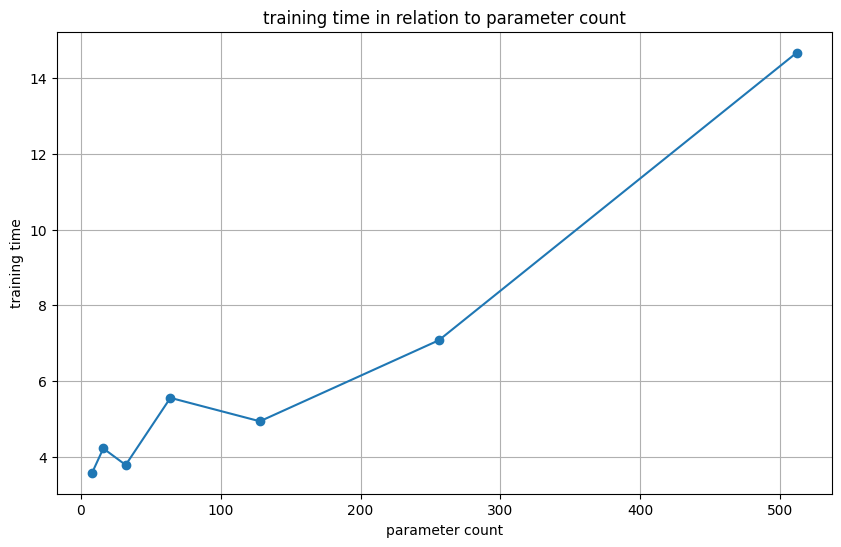

In [43]:
# fromm prev assignment
val_loss = [i[0] for i in eval_array]
val_accuracy = [i[1] for i in eval_array]
training_time = [i[2] for i in eval_array]
param_count = [i[3] for i in eval_array]



# val_acc
plt.figure(figsize=(10, 6))
plt.plot(param_count, val_accuracy, marker='o')
plt.xlabel('parameter count')
plt.ylabel('validation accuracy')
plt.title('validation accuracy in relation to parameter count')
plt.grid(True)
plt.show()

# val_loss
plt.figure(figsize=(10, 6))
plt.plot(param_count, val_loss, marker='o')
plt.xlabel('parameter count')
plt.ylabel('Validation Loss')
plt.title('validation loss in relation to parameter count')
plt.grid(True)
plt.show()

# training_time 
plt.figure(figsize=(10, 6))
plt.plot(param_count, training_time, marker='o')
plt.xlabel('parameter count')
plt.ylabel('training time')
plt.title('training time in relation to parameter count')
plt.grid(True)
plt.show()

# Report Accuracy and Loss

## More parameters result in: 

- higher accuracy -> however if you have a higher parameter count than 64, the accuracy reduces again, but is still better than everything under 32 parameters
- lower loss -> but again, if you have a higher parameter count than 64, the loss rises again, but is still better than everything under 32 parameters
- higher training time (except for 128 for some reason, i guess it was because of the EarlyStopping)


In [44]:
predict_durations

[[0.287064790725708, 512],
 [0.2892117500305176, 256],
 [0.2840869426727295, 128],
 [0.278062105178833, 64],
 [0.279691219329834, 32],
 [0.2770678997039795, 16],
 [0.28166770935058594, 8]]

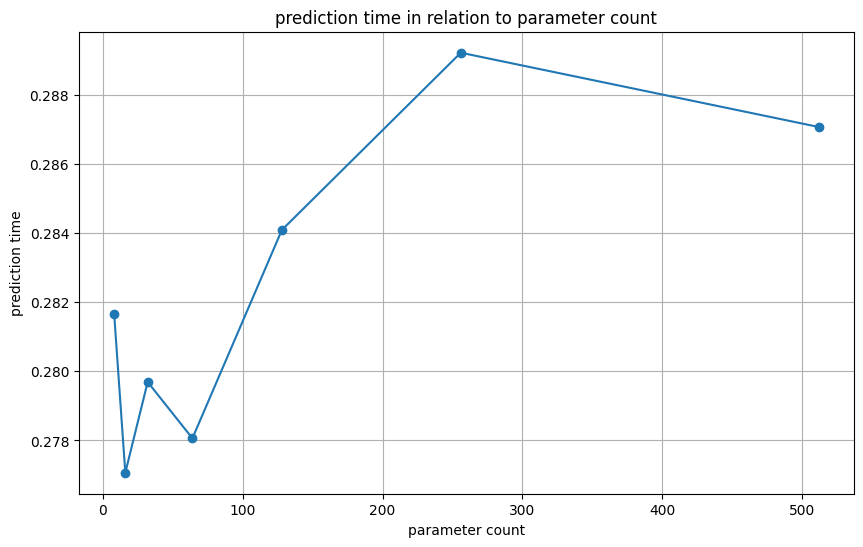

In [45]:
#from prev assignment
params = [i[1] for i in predict_durations]
prediction_time = [i[0] for i in predict_durations]

plt.figure(figsize=(10, 6))
plt.plot(params, prediction_time, marker='o')
plt.xlabel('parameter count')
plt.ylabel('prediction time')
plt.title('prediction time in relation to parameter count')
plt.grid(True)
plt.show()

# Report Prediction Time

## More parameters result in: 

- higher prediction time, however fewer parameters (like 8 or 16) also perform not as good as 32 or 64 parameters, at least for this particular purpose
- but if you look at the dimensions in which the values are, you could say, that the prediction times are kinda equal

# Which one would I use for a practical application
For the LSTMs I would choose the parameter count 64. It has the highest accuracy, lowest prediction time and lowest loss of all the different models with different parameter counts. If you compare 1$ recognizer with LSTM, it depends on the application you want to build. If you need an application with a efficient and fast prediction I would use the 1$ recognizer. If you want an application that achieves high accuracy I would use an LSTM. However if you want to achieve a really high accuracy you need a big dataset, while you only need a few templates when using the 1$ recognizer.

-> for a practical application I would use the 1$ recognizer. It's easy to implement(copy from https://depts.washington.edu/acelab/proj/dollar/index.html) and if you need to add some gestures afterwards, you can just add a template, instead of training a whole LSTM again with a even bigger dataset...
 